In [1]:
import torch as tc      
tc.cuda.is_available()

True

# Tensor and Gradient
## Tensor


In [2]:
t1 = tc.tensor(4)
print(t1)
print(t1.dtype)

t2 = tc.tensor([1,2,3,4,5])
print(t2)
print(t2.dtype)
print(t2.shape)

mat = tc.tensor([[1,2],[3,4]])
print(mat)

twothree = tc.tensor([[1,2,3],[4,5,6]])
print(twothree)
print(twothree.shape)
print(twothree.size())




tensor(4)
torch.int64
tensor([1, 2, 3, 4, 5])
torch.int64
torch.Size([5])
tensor([[1, 2],
        [3, 4]])
tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])
torch.Size([2, 3])


## Gradient

In [3]:
# These tensors are just scalar
x = tc.tensor(3)  # Only to the tensors that we really needs the gradient
w = tc.tensor(4., requires_grad=True)
b = tc.tensor(5., requires_grad=True)

# Arithmetic operation
y = w*x + b
print(y)

# Calculate gradients
y.backward() # Call this to trigger grad calculation
print('dy/dx ', x.grad) 
print('dy/dw ', w.grad) #.grad attributes is wrt to the y.backward()
print('dy/db ', b.grad)



tensor(17., grad_fn=<AddBackward0>)
dy/dx  None
dy/dw  tensor(3.)
dy/db  tensor(1.)


## With Numpy


In [4]:
import numpy as np
x = np.array([[1,2],[3,4]])
print(x)
print(x.dtype)
y = tc.from_numpy(x)
print(y)
print(y.dtype)
z = y.numpy()
print(x - z)


[[1 2]
 [3 4]]
int64
tensor([[1, 2],
        [3, 4]])
torch.int64
[[0 0]
 [0 0]]


# Linear Regression


In [5]:
input = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
                   # Targets (apples, oranges)
output = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

input_tc = tc.from_numpy(input)
output_tc = tc.from_numpy(output)
print(input_tc)
print(output_tc)

# y = w*x + b
w = tc.tensor([[-2.7558,  1.4785],
        [-0.1469, -0.3173],
        [-0.0935, -0.7446]], requires_grad = True)
b = tc.tensor([ 0.2452, -0.3965], requires_grad = True)
print("w")
print(w)
print("b")
print(b)



tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])
w
tensor([[-2.7558,  1.4785],
        [-0.1469, -0.3173],
        [-0.0935, -0.7446]], requires_grad=True)
b
tensor([ 0.2452, -0.3965], requires_grad=True)


In [6]:

def model(x): 
    return x @ w + b
def mse(t1,t2):
    diff = (t1 - t2)
    return tc.sum((diff*diff)/diff.numel()) # numel = number of element
    

In [7]:
# Prediction
preds = model(input_tc)
print(preds)
print(output_tc)

loss = mse (preds, output_tc)
print(loss)
loss.backward()


tensor([[-214.7910,   54.2571],
        [-269.4438,   58.5702],
        [-264.6170,   42.5280],
        [-290.6226,  109.2164],
        [-210.5524,   19.0372]], grad_fn=<AddBackward0>)
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])
tensor(56478.9727, grad_fn=<SumBackward0>)


In [8]:
# Compute gradient of loss wrt to the components
print(w)
print(w.grad)
print(b)
print(b.grad)

tensor([[-2.7558,  1.4785],
        [-0.1469, -0.3173],
        [-0.0935, -0.7446]], requires_grad=True)
tensor([[-27711.0879,  -2482.5532],
        [-28786.1074,  -4680.5933],
        [-17967.5820,  -2593.0432]])
tensor([ 0.2452, -0.3965], requires_grad=True)
tensor([-326.2054,  -35.2782])


In [9]:
rate = 1e-5
with tc.no_grad():
    w -= w.grad*rate
    b -= b.grad*rate
    w.grad.zero_()
    b.grad.zero_()

In [10]:

loss_over_time = []
for i in range(100):
    preds = model(input_tc)
    loss = mse(preds, output_tc)
    loss_over_time.append(loss.detach().numpy())
    loss.backward()
    with tc.no_grad(): # Turn off the gradient feature to reduce memory while update
        w -= w.grad*rate
        b -= b.grad*rate
        w.grad.zero_()
        b.grad.zero_()

In [11]:
import matplotlib.pyplot as plt


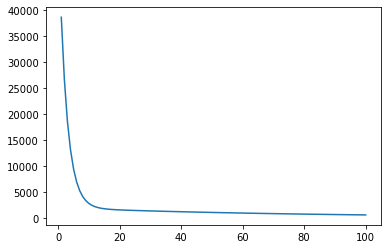

In [12]:
x = np.linspace(1,len(loss_over_time),num = len(loss_over_time))

plt.plot(x, loss_over_time)

## Dataset and DataLoader


In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn


In [14]:
train_ds = TensorDataset(input_tc, output_tc) # Input Output
print(type(train_ds))
train_ds[0]

<class 'torch.utils.data.dataset.TensorDataset'>


(tensor([73., 67., 43.]), tensor([56., 70.]))

In [15]:
BATCH_SIZE = 5
train_dataloader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
for xb, yb in train_dataloader:
    print("batch")
    print(xb)
    print(yb)


batch
tensor([[ 69.,  96.,  70.],
        [ 87., 134.,  58.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [102.,  43.,  37.]])
tensor([[103., 119.],
        [119., 133.],
        [ 56.,  70.],
        [ 81., 101.],
        [ 22.,  37.]])


In [16]:
model = nn.Linear(3,2)
print(model.weight)
print(model.bias)
list(model.parameters())

Parameter containing:
tensor([[-0.2585, -0.4612, -0.1896],
        [-0.0336, -0.4540,  0.3737]], requires_grad=True)
Parameter containing:
tensor([-0.3565,  0.1285], requires_grad=True)


[Parameter containing:
 tensor([[-0.2585, -0.4612, -0.1896],
         [-0.0336, -0.4540,  0.3737]], requires_grad=True),
 Parameter containing:
 tensor([-0.3565,  0.1285], requires_grad=True)]

In [17]:
preds = model(input_tc)
preds

tensor([[-58.2846, -16.6769],
        [-76.6059, -18.9686],
        [-95.6497, -41.9625],
        [-53.5748,  -8.9980],
        [-75.7460, -19.6184]], grad_fn=<AddmmBackward0>)

In [18]:
import torch.nn.functional as F
loss_fn = F.mse_loss
loss = loss_fn(model(input_tc), output_tc)
print(loss)



tensor(19548.4883, grad_fn=<MseLossBackward0>)


In [19]:
optimize = tc.optim.SGD(model.parameters(), lr = 1e-5)
?tc.optim.SGD

Init signature:
tc.optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
    *,
    maximize=False,
    foreach: Union[bool, NoneType] = None,
)
Docstring:     
Implements stochastic gradient descent (optionally with momentum).

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
            \text{ (objective)}, \: \lambda \text{ (weight decay)},                          \\
        &\hspace{13mm} \:\mu \text{ (momentum)}, \:\tau \text{ (dampening)},
        \:\textit{ nesterov,}\:\textit{ maximize}                                     \\[-1.ex]
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
        &\hspace{5m

In [20]:
def fit(EPOCH, model, loss_fn, optimize):
    for epoch in range(EPOCH):
        for xb, yb in train_dataloader:
            loss = loss_fn(model(xb), yb) # The function that we want the error to be the lowest
            loss.backward()
            optimize.step() # Update the parameter using the gradient SGD
            optimize.zero_grad() # Reset the grad of the parameter
        if (epoch+1)% 10 ==0:
            print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1,EPOCH,loss))


In [21]:
fit(1000,model, loss_fn, optimize)

Epoch [10/1000], Loss: 1163.1074
Epoch [20/1000], Loss: 559.6546
Epoch [30/1000], Loss: 484.5746
Epoch [40/1000], Loss: 427.2568
Epoch [50/1000], Loss: 376.9379
Epoch [60/1000], Loss: 332.6158
Epoch [70/1000], Loss: 293.5718
Epoch [80/1000], Loss: 259.1765
Epoch [90/1000], Loss: 228.8750
Epoch [100/1000], Loss: 202.1792
Epoch [110/1000], Loss: 178.6587
Epoch [120/1000], Loss: 157.9351
Epoch [130/1000], Loss: 139.6746
Epoch [140/1000], Loss: 123.5836
Epoch [150/1000], Loss: 109.4031
Epoch [160/1000], Loss: 96.9056
Epoch [170/1000], Loss: 85.8903
Epoch [180/1000], Loss: 76.1806
Epoch [190/1000], Loss: 67.6206
Epoch [200/1000], Loss: 60.0735
Epoch [210/1000], Loss: 53.4184
Epoch [220/1000], Loss: 47.5493
Epoch [230/1000], Loss: 42.3722
Epoch [240/1000], Loss: 37.8049
Epoch [250/1000], Loss: 33.7748
Epoch [260/1000], Loss: 30.2178
Epoch [270/1000], Loss: 27.0776
Epoch [280/1000], Loss: 24.3047
Epoch [290/1000], Loss: 21.8554
Epoch [300/1000], Loss: 19.6911
Epoch [310/1000], Loss: 17.7780
E

# Image Classification


In [22]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transform # Transform other data types into tensors



In [23]:
dataset = MNIST(root='data/', download=True)
len(dataset)

60000

In [24]:
test_dataset = MNIST(root="data/", train = False)
len(test_dataset)

10000

<class 'tuple'>
<class 'PIL.Image.Image'>
<class 'int'>
5


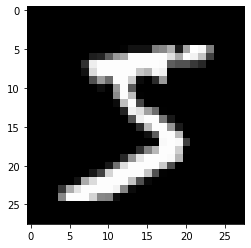

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
image, label = dataset[0]
print(type(dataset[0]))
print(type(image))
print(type(label))
plt.imshow(image, cmap="gray")
print(label)

In [26]:
dataset = MNIST(root="data/", train=True, transform = transform.ToTensor()) # This is only applicable to MNIST

# Transform to  C x H x W

img_tensor, label = dataset[0]
print(img_tensor.shape, label)
print(img_tensor[0][10:15])

torch.Size([1, 28, 28]) 5
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0549, 0.0039, 0.6039, 0.9922, 0.3529, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.5451, 0.9922, 0.7451, 0.0078, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0431, 0.7451, 0.9922, 0.2745, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1373, 0.9451, 0.8824, 0.6275, 0.4235, 0.0039,
         0.0000, 0.0000, 0.00

In [27]:
# Train test Validate
from sklearn. model_selection import train_test_split
import sklearn


In [28]:
'''
class CustomModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.con1 = nn.Conv2d(2, 2, 3)
        self.con2 = nn.Conv2d(2, 3, 3)

    def forward(self, X):
        x = self.con1(x)
        x = self.con2(x)
        return X

model = CustomModule(input, output)
opt = tc.optim.SGD(model.parameters(), lr = 0.1) # the model is a child class of nn.Module, hence, it has method parameters()
F.mse_loss

# Training process

for epoch in range(EPOCH_NUM): # Run epoch
    for input,output in DataLoad: # Update after 1 batch
        predict = model.forward(input)
        loss = F.mse_loss(predict, output)
        loss.backward()
        opt.step()
        opt.zero_grad()

'''


'\nclass CustomModule(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.con1 = nn.Conv2d(2, 2, 3)\n        self.con2 = nn.Conv2d(2, 3, 3)\n\n    def forward(self, X):\n        x = self.con1(x)\n        x = self.con2(x)\n        return X\n\nmodel = CustomModule(input, output)\nopt = tc.optim.SGD(model.parameters(), lr = 0.1) # the model is a child class of nn.Module, hence, it has method parameters()\nF.mse_loss\n\n# Training process\n\nfor epoch in range(EPOCH_NUM):\n    predict = model.forward(input)\n    loss = F.mse_loss(predict, output)\n    loss.backward()\n    opt.step()\n    opt.zero_grad()\n'

In [29]:
import torch
import torchvision
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data
breastCancer = datasets.load_breast_cancer()

In [30]:
# Preparing the data
X, y = breastCancer.data, breastCancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
# Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = tc.from_numpy(X_train.astype(np.float32))
X_test = tc.from_numpy(X_test.astype(np.float32))
y_train = tc.from_numpy(y_train.astype(np.float32))
y_test = tc.from_numpy(y_test.astype(np.float32))
y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)

print(y_train)


tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [37]:
import os
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {}".format(device))


Using cuda


In [40]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        return logits


model = CustomModel().to(device)
print(model)

CustomModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [50]:
X = torch.rand(1,28,28,device = device)
logits = model(X)
pred_prob = nn.Softmax(dim = 1)(logits)
y_pred = pred_prob.argmax(1)
print(pred_prob)
print(y_pred)

tensor([[0.0874, 0.1001, 0.0985, 0.1023, 0.1038, 0.0992, 0.0872, 0.1136, 0.0991,
         0.1090]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([7], device='cuda:0')


In [52]:
print(model)

CustomModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [31]:
# def wrapper(original):
#     import stuff
#     def wrapper_func(*args, **kwargs):
#         do_more_things
#         return original(*args, **kwargs)
#     return wrapper


# display = wrapper(display)
# function_pointer = display
# function_trigger = display() 